## Test 1: basic Thornthwaite-Mather water budget

This test combines the most commonly used SWB2 program options and completes a model run using tabular precipitation and air tempterature inputs. The output is compared to the same calculations made using a simple Python version of the same algorithms.

For this test, a curve number of '0' is used in the SWB run, essentially ensuring that there is never any runoff calculated in SWB. This is done to make the initial comparison to the Thornthwaite-Mather soil-moisture-retention tables easier to understand. The only active sources of water are rainfall and snowmelt; the sinks are actual evapotranspiration and net infiltration. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib as pl
import sys
import subprocess

#### Define paths to swb2 executable and working/input data directories

In [2]:
base_dir = str(pl.Path.cwd().parent)
python_script_dir = pl.Path.cwd().parent / 'python'
swb_work_dir = pl.Path.cwd().parent / 'swb_work'
logfile_dir = pl.Path.cwd().parent / 'logfiles'
test_data_dir = pl.Path.cwd().parent / 'test_data'
tm_table_file = test_data_dir / 'Thornthwaite_soil_moisture_retention_tables__millimeters.csv'
output_dir = pl.Path.cwd().parent / 'output'
swb2_executable = str(pl.Path.cwd().parent / 'bin' /'swb2.exe')
sys.path.append(str(python_script_dir))

from swb_cell import SWBCell
import run_management as rm

In [3]:
# Show me all of the columns of the dataframe...
pd.set_option('display.max_columns', None)

In [4]:
tm_soil_moisture_retention_df = pd.read_csv(tm_table_file)

In [27]:
tm_soil_moisture_retention_df

,apwl_mm,sz_25,sz_50,sz_75,sz_100,sz_300,sz_300_calc,sz_300_aet_calc
0,0,25.0,50.0,75.0,100.0,300,300.000,0.0000
1,1,24.0,49.0,74.0,99.0,299,299.002,0.9983
2,2,23.0,48.0,73.0,98.0,298,298.007,0.9950
3,3,22.0,47.0,72.0,97.0,297,297.015,0.9917
4,4,21.0,46.0,71.0,96.0,296,296.027,0.9884
...,...,...,...,...,...,...,...,...
1495,1495,NaN,NaN,NaN,NaN,2,2.055,0.0069
1496,1496,NaN,NaN,NaN,NaN,2,2.049,0.0068
1497,1497,NaN,NaN,NaN,NaN,2,2.042,0.0068
1498,1498,NaN,NaN,NaN,NaN,2,2.035,0.0068


In [30]:
def get_aet_for_given_apwl(apwl, tm_df):
    ss = tm_df.query(f"apwl_mm == {apwl}")
    return ss['sz_300']

In [33]:
def find_nearest_value(df, value):

    return df.iloc[(df['sz_300']-value).abs().argsort()[:2]]

In [34]:
find_nearest_value(tm_soil_moisture_retention_df, 47)

,apwl_mm,sz_25,sz_50,sz_75,sz_100,sz_300,sz_300_calc,sz_300_aet_calc
552,552,NaN,NaN,NaN,NaN,47,47.645,0.1591
550,550,NaN,NaN,NaN,NaN,47,47.964,0.1601


#### Remove and replace working directories for swb2 run

In [6]:
rm.destroy_model_work_output_and_logfile_dirs(base_dir=base_dir,
                                              swb_work_dir=swb_work_dir,
                                              logfile_dir=logfile_dir,
                                              output_dir=output_dir)
rm.create_model_work_output_and_logfile_dirs(base_dir=base_dir,
                                             swb_work_dir=swb_work_dir,
                                             logfile_dir=logfile_dir,
                                             output_dir=output_dir)


#### Make a new swb2 model run for a single cell example

In the following step, a new swb2 model run is started using a pre-configured swb control file. The swb model contains a single cell. Daily weather data is a table of precipitation and tmax/tmin values. The test case is centered on the airport at Kenai, Alaska.

In [7]:
dry_run = False
lookup_dir_arg_text = f"--lookup_dir={str(test_data_dir)}"
weather_data_dir_arg_text = f"--weather_data_dir={str(test_data_dir)}"
output_dir_arg_text = f"--output_dir={str(output_dir)}"
logfile_dir_arg_text = f"--logfile_dir={str(logfile_dir)}"
control_file_path = str(test_data_dir / 'swb_control_file_kenai.ctl')
output_prefix = '--output_prefix=swb_kenai_'

swb_arg_text = [swb2_executable, output_dir_arg_text, lookup_dir_arg_text, weather_data_dir_arg_text, output_prefix, logfile_dir_arg_text, control_file_path]

f = open("stdout.txt", "w")

if not dry_run:
  with rm.cd(swb_work_dir):
#    p = subprocess.Popen(swb_arg_text, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    p = subprocess.Popen(swb_arg_text, stdout=f, stderr=subprocess.DEVNULL)
    p.wait()

#### Read in swb2 model results

In [8]:
swb_df = pd.read_csv(pl.Path(output_dir, 'SWB2_variable_values__Kenai_Airpt__col_1__row_1__x_150393__y_1179331.csv'))
# eliminate pesky spaces around column names
swb_df.columns = swb_df.columns.str.replace(' ', '')
swb_df.columns

Index(['date', 'month', 'day', 'year', 'landuse_code', 'landuse_index',
       'soil_group', 'num_upslope_connections', 'sum_upslope_cells',
       'solution_order', 'cell_index', 'target_index', 'awc', 'latitude',
       'reference_ET0', 'actual_ET', 'curve_num_adj', 'gross_precip', 'inflow',
       'runon', 'runoff', 'outflow', 'infiltration', 'snowfall',
       'potential_snowmelt', 'snowmelt', 'interception', 'rainfall',
       'net_rainfall', 'monthly_gross_precip', 'monthly_runoff',
       'interception_storage', 'tmax', 'tmin', 'tmean', 'snow_storage',
       'soil_storage', 'soil_storage_max', 'evaporable_water_storage',
       'evaporable_water_deficit', 'delta_soil_storage',
       'soil_moisture_deficit', 'surface_storage', 'surface_storage_excess',
       'surface_storage_max', 'net_infiltration', 'rejected_net_infiltration',
       'fog', 'irrigation', 'gdd', 'runoff_outside', 'pervious_fraction',
       'storm_drain_capture', 'canopy_cover_fraction', 'crop_coefficient_kcb

#### Convert swb Imperial units to metric

In [9]:
swb_df['tminf'] = swb_df.loc[:,'tmin']
swb_df['tmaxf'] = swb_df.loc[:,'tmax']
swb_df['tmeanf'] = swb_df.loc[:,'tmean']
swb_df.loc[:,'tmin'] = (swb_df.loc[:,'tmin'] - 32) / 1.8
swb_df.loc[:,'tmax'] = (swb_df.loc[:,'tmax'] - 32) / 1.8
swb_df.loc[:,'tmean'] = (swb_df.loc[:,'tmean'] - 32) / 1.8
swb_df.loc[:,'gross_precip'] = swb_df.loc[:,'gross_precip'] * 25.4
swb_df.loc[:,'actual_ET'] = swb_df.loc[:,'actual_ET'] * 25.4
swb_df.loc[:,'reference_ET0'] = swb_df.loc[:,'reference_ET0'] * 25.4
swb_df.loc[:,'soil_storage'] = swb_df.loc[:,'soil_storage'] * 25.4
swb_df.loc[:,'snow_storage'] = swb_df.loc[:,'snow_storage'] * 25.4
swb_df.loc[:,'snowfall'] = swb_df.loc[:,'snowfall'] * 25.4
swb_df.loc[:,'snowmelt'] = swb_df.loc[:,'snowmelt'] * 25.4
swb_df.loc[:,'net_infiltration'] = swb_df.loc[:,'net_infiltration'] * 25.4
swb_df.loc[:,'infiltration'] = swb_df.loc[:,'infiltration'] * 25.4

swb_df['date'] = pd.to_datetime(swb_df['date'])

#### Create a Python version of a swb2 cell

In [10]:
# swb2 still uses Imperial units (inches and feet); the Python code expects metric units (mm and m).
# The example control file we're using for swb2 specifies 3.6 inches/foot for the available water capacity.
# 3.6 inches per foot equals 300 mm/m. The rooting depth is specified in the swb2 lookup table as 1.6404 feet, 
# or 1.6404 ft / 3.2808 ft/m = 0.5 m
mycell = SWBCell(latitude=60.57154, available_water_capacity=300., rooting_depth=0.5)

Spurious LaTeX math example here

$$
f(x) = \int_{-\infty}^{\infty} e^{-x^2} dx
$$


#### Initialize a Python version of swb

In [11]:
mycell.init_swb_cell()

#### Iterate and solve the water budget in Python over the date range contained in the swb2 output file

In [12]:
for index, row in swb_df.iterrows():
    mycell.calc_cell_water_budget(int(row['year']),int(row['month']),int(row['day']),
                                  row['tmin'],row['tmax'],row['tmean'],row['gross_precip'])
    mycell.variables_todict()

#### Convert the output dictionary to a dataframe

In [13]:
mycell.convert_dict_to_df()
py_df = mycell.output_df.copy()
py_df.loc[:,'date'] = pd.to_datetime(py_df['date'])

#### Merge the swb and python model outputs into a single dataframe

In [14]:
df = pd.merge(left=swb_df, right=py_df, on='date', suffixes=('_s','_p'))
df.columns

Index(['date', 'month', 'day', 'year', 'landuse_code', 'landuse_index',
       'soil_group', 'num_upslope_connections', 'sum_upslope_cells',
       'solution_order', 'cell_index', 'target_index', 'awc', 'latitude',
       'reference_ET0', 'actual_ET', 'curve_num_adj', 'gross_precip', 'inflow',
       'runon', 'runoff', 'outflow', 'infiltration', 'snowfall_s',
       'potential_snowmelt', 'snowmelt_s', 'interception', 'rainfall_s',
       'net_rainfall', 'monthly_gross_precip', 'monthly_runoff',
       'interception_storage', 'tmax', 'tmin', 'tmean', 'snow_storage_s',
       'soil_storage_s', 'soil_storage_max', 'evaporable_water_storage',
       'evaporable_water_deficit', 'delta_soil_storage',
       'soil_moisture_deficit', 'surface_storage', 'surface_storage_excess',
       'surface_storage_max', 'net_infiltration_s',
       'rejected_net_infiltration', 'fog', 'irrigation', 'gdd',
       'runoff_outside', 'pervious_fraction', 'storm_drain_capture',
       'canopy_cover_fraction', 'c

In [15]:
# estimate 'P minus PET' for swb
df['p_minus_pet_s'] = (df['snowmelt_s'] + df['rainfall_s'] - df['crop_etc']) * 25.4

In [16]:
my_subset = df[(df['date'] > "1967-05-01") & (df['date'] < "1967-05-20")]
#my_subset[['date','tmin','tmax','tmean','tminf','tmaxf','tmeanf','gross_precip','soil_storage_s','soil_storage_p',
#           'infiltration', 'p_minus_pet_s','p_minus_pet',
#           'reference_ET0','pet','actual_ET','aet']]

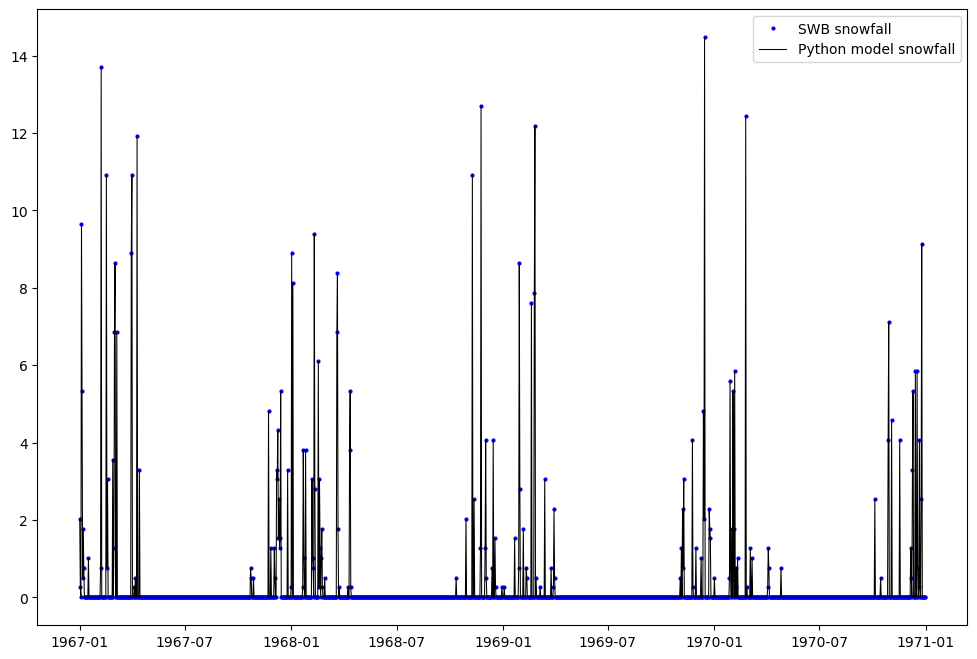

In [17]:
fig, ax = plt.subplots(1,1,figsize=(12, 8),sharex=False)
ax.plot(df['date'], df['snowfall_s'], marker='.', linestyle=' ', color='blue', markersize=4, label='SWB snowfall')
ax.plot(df['date'], df['snowfall_p'], marker=' ', linestyle='-', 
        color='black', linewidth=0.75, label='Python model snowfall')
ax.legend()

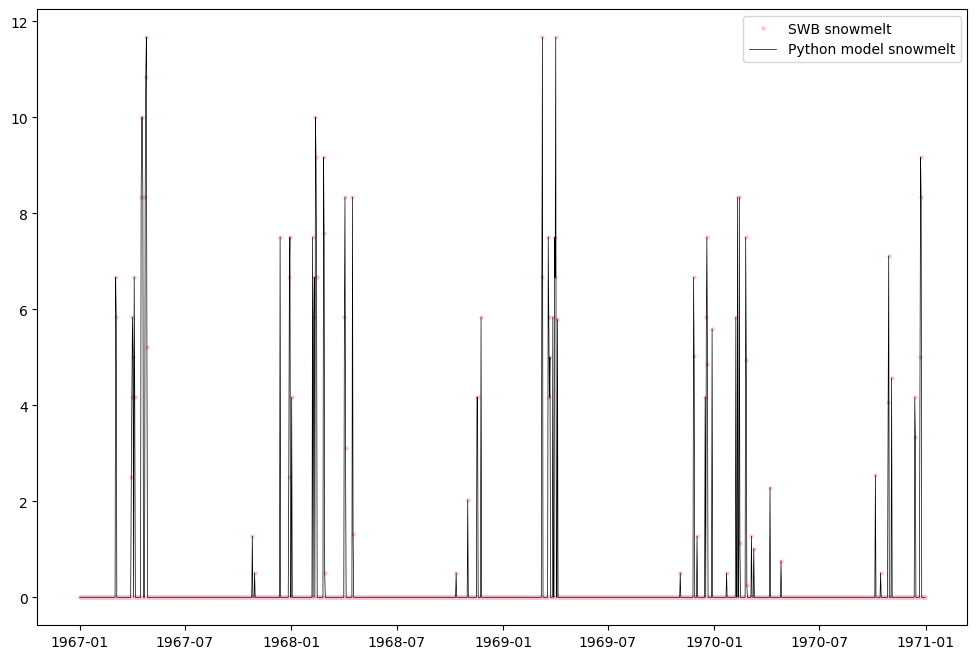

In [18]:
fig, ax = plt.subplots(1,1,figsize=(12, 8),sharex=False)
ax.plot(df['date'], df['snowmelt_s'], marker='.', linestyle=' ', color='pink', markersize=4, label='SWB snowmelt')
ax.plot(df['date'], df['snowmelt_p'], marker=' ', linestyle='-', 
        color='black', linewidth=0.5, label='Python model snowmelt')
ax.legend()

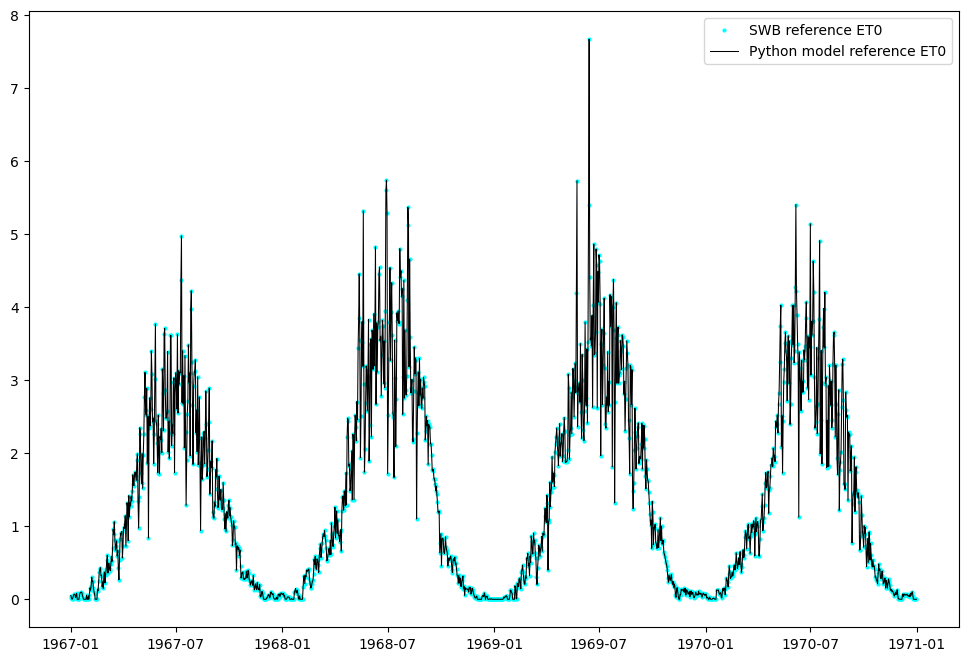

In [19]:
fig, ax = plt.subplots(1,1,figsize=(12, 8),sharex=False)
ax.plot(df['date'], df['reference_ET0'], marker='.', linestyle=' ', color='cyan', markersize=4, label='SWB reference ET0')
ax.plot(df['date'], df['pet'], marker=' ', linestyle='-', 
        color='black', linewidth=0.75, label='Python model reference ET0')
ax.legend()

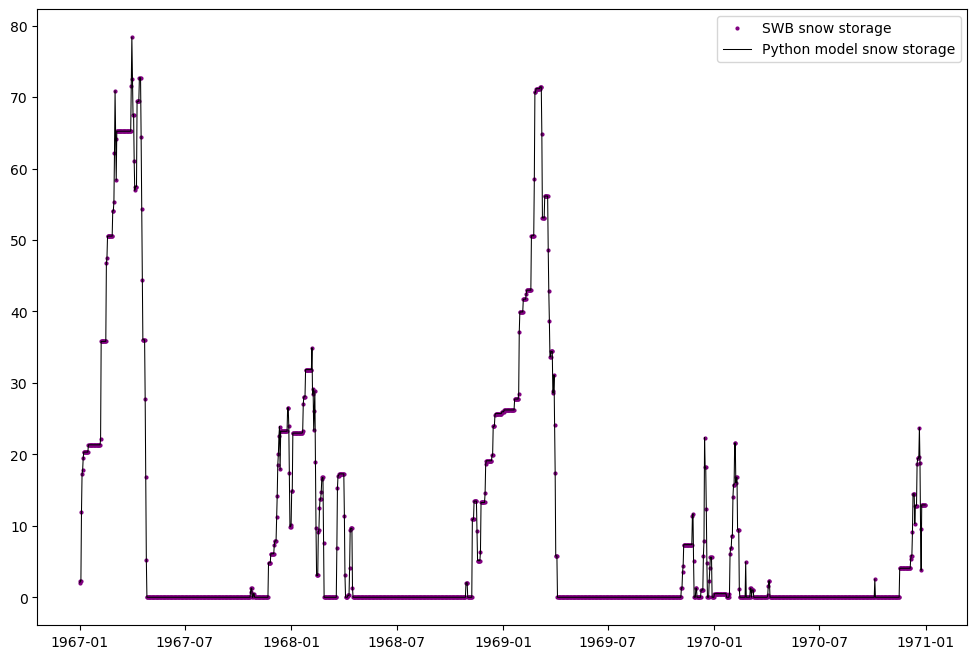

In [20]:
fig, ax = plt.subplots(1,1,figsize=(12, 8),sharex=False)
ax.plot(df['date'], df['snow_storage_s'], marker='.', linestyle=' ', color='purple', markersize=4, label='SWB snow storage')
ax.plot(df['date'], df['snow_storage_p'], marker=' ', linestyle='-', 
        color='black', linewidth=0.75, label='Python model snow storage')
ax.legend()

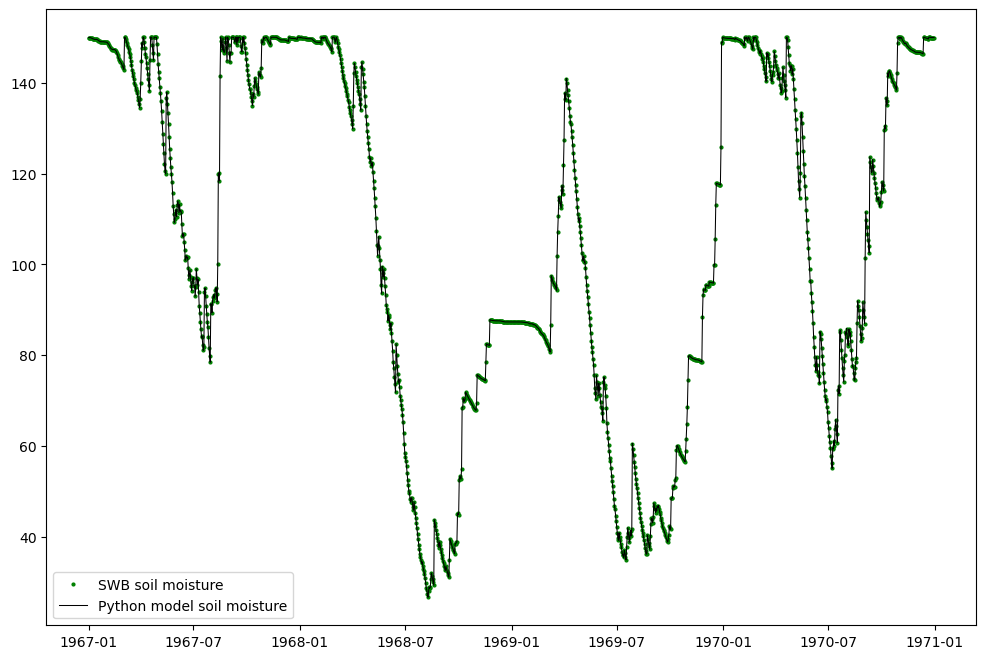

In [21]:
fig, ax = plt.subplots(1,1,figsize=(12, 8),sharex=False)
ax.plot(df['date'], df['soil_storage_s'], marker='.', linestyle=' ', color='green', markersize=4, label='SWB soil moisture')
ax.plot(df['date'], df['soil_storage_p'], marker=' ', linestyle='-', 
        color='black', linewidth=0.75, label='Python model soil moisture')
ax.legend()
#ax2 = ax.twinx()
#ax2.plot(df['date'], df['infiltration'], color='blue', linewidth=0.4)
#ax2.plot(df['date'], df['infiltration'], color='blue', marker='.', markersize=8)


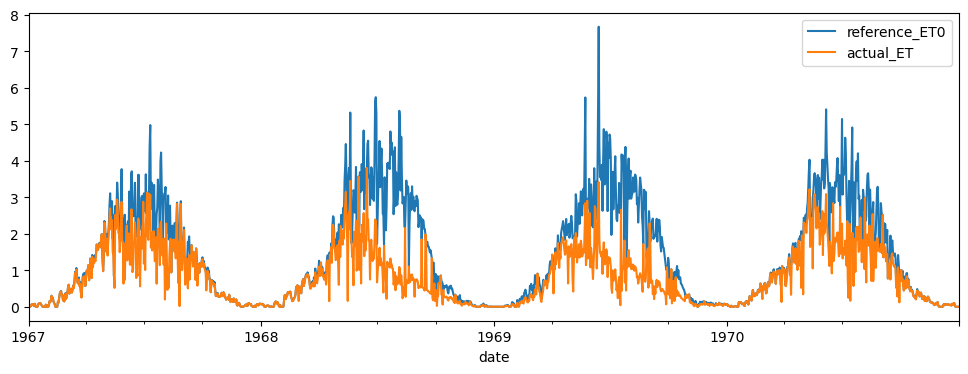

In [22]:
myplot = df.plot('date',['reference_ET0','actual_ET'], figsize=(12,4))

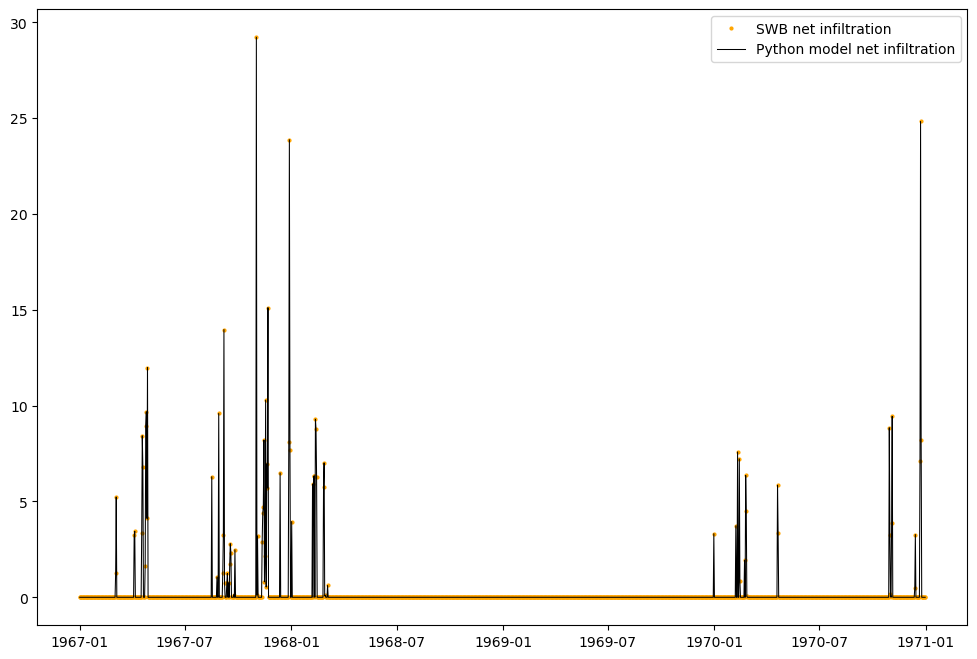

In [23]:
fig, ax = plt.subplots(1,1,figsize=(12, 8),sharex=False)
ax.plot(df['date'], df['net_infiltration_s'], marker='.', linestyle=' ', color='orange', markersize=4, label='SWB net infiltration')
ax.plot(df['date'], df['net_infiltration_p'], marker=' ', linestyle='-', 
        color='black', linewidth=0.75, label='Python model net infiltration')
ax.legend()

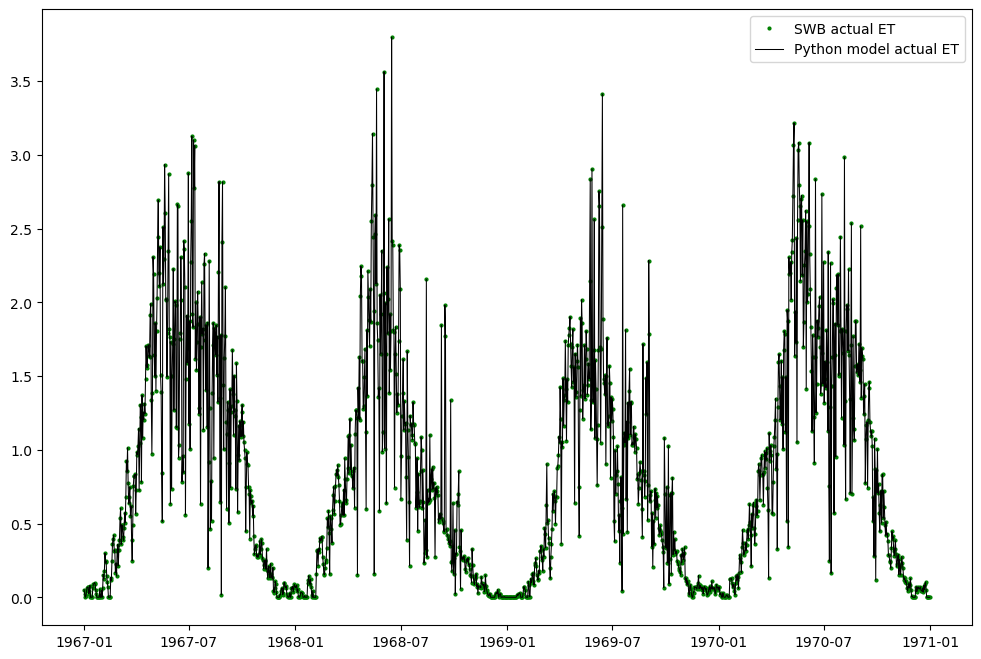

In [24]:
fig, ax = plt.subplots(1,1,figsize=(12, 8),sharex=False)
ax.plot(df['date'], df['actual_ET'], marker='.', linestyle=' ', color='green', markersize=4, label='SWB actual ET')
ax.plot(df['date'], df['aet'], marker=' ', linestyle='-', color='black',
        linewidth=0.75, label='Python model actual ET')
ax.legend()